# PPO-Based Portfolio Rebalancing with Reinforcement Learning

In this notebook, we implement a **Reinforcement Learning-based portfolio rebalancer** using the **Proximal Policy Optimization (PPO)** algorithm. The objective is to dynamically adjust asset allocations across a diverse set of stocks in order to **maximize long-term returns**, while accounting for **risk exposure** and **transaction costs**.

## Portfolio Universe

The model is trained on a portfolio of **15 large-cap U.S. stocks** across various sectors, including:

- Technology: AAPL, MSFT, NVDA, GOOGL, META, AMZN, TSLA  
- Financials: JPM, MA  
- Healthcare: UNH, JNJ  
- Energy: XOM  
- Industrials: BA  
- Utilities: NEE  
- Consumer Staples: KO

## Key Features

- **Multi-asset support** across diversified sectors  
- Custom **OpenAI Gym-compatible environment**  
- **Continuous action space** representing allocation weights  
- Reward function incorporates **log returns** and **transaction cost penalties**  
- Evaluation against baseline strategies:
  - **Buy-and-Hold**
  - **Equal Weight**


## Install Dependencies

In [1]:
!pip install -q gymnasium==0.29.1 stable-baselines3==2.2.1 shimmy yfinance matplotlib pandas numpy ta

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.7/181.7 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 121.3 MB/s eta 0:00:00

## Import Libraries

In [97]:
import gymnasium as gym
import numpy as np
import pandas as pd
import yfinance as yf
from gymnasium import spaces
from gymnasium.wrappers import RecordEpisodeStatistics
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize, VecMonitor
from stable_baselines3.common.callbacks import EvalCallback
from matplotlib import pyplot as plt

## 1: Data Download Utility

In [105]:
def download_data(tickers, start, end):
    """
    Download adjusted historical price data and compute log returns.

    Parameters:
        tickers (list of str): List of stock ticker symbols.
        start (str): Start date in 'YYYY-MM-DD' format.
        end (str): End date in 'YYYY-MM-DD' format.

    Returns:
        pd.DataFrame: DataFrame of log returns indexed by date.
    """
    # Download price data using yfinance with adjusted close prices
    df = yf.download(tickers, start=start, end=end, auto_adjust=True, progress=False)

    # Extract only closing prices; handle multi-index vs flat columns
    if isinstance(df.columns, pd.MultiIndex):
        prices = df['Close'][tickers]
    else:
        prices = df[['Close']]
        prices.columns = tickers

    # Clean and compute log returns
    prices = prices.dropna()
    log_returns = np.log(prices / prices.shift(1)).dropna()
    return log_returns

## 2: Custom Gym Environment

In [106]:
class PortfolioEnv(gym.Env):
    """
    A custom Gym environment for training reinforcement learning agents
    on financial portfolio allocation using historical log returns.

    The agent receives observations containing recent return history
    and previous portfolio weights, takes portfolio allocation actions,
    and receives a multi-objective reward combining Sortino ratio and
    transaction-penalized log return.

    Parameters:
        price_df (pd.DataFrame): DataFrame of asset log returns.
        window_size (int): Number of past days used in each observation.
        trading_cost (float): Proportional cost per unit turnover.
        reward_window (int): Window size for rolling Sortino computation.
        reward_alpha (float): Weight factor between return and Sortino in reward.
    """
    def __init__(self, price_df, window_size=30, trading_cost=0.001, reward_window=20, reward_alpha=0.1):
        super().__init__()
        self.price_df = price_df.replace([np.inf, -np.inf], np.nan).dropna()
        self.tickers = list(self.price_df.columns)
        self.n_assets = len(self.tickers)
        self.window_size = window_size
        self.trading_cost = trading_cost
        self.reward_window = reward_window
        self.reward_alpha = reward_alpha

        # Action space: asset weights in the portfolio (normalized by softmax)
        self.action_space = spaces.Box(0.0, 1.0, (self.n_assets,), dtype=np.float32)

        # Observation space: for each timestep, the past returns + past weights
        self.observation_space = spaces.Box(
            -np.inf, np.inf,
            (self.window_size, self.n_assets * 2),
            dtype=np.float32
        )

        self.reset()

    def reset(self, seed=None, options=None):
        """
        Reset the environment to the initial state.

        Returns:
            obs (np.ndarray): Initial observation.
        """
        super().reset(seed=seed)
        self.current_idx = self.window_size
        self.prev_weights = np.ones(self.n_assets) / self.n_assets
        self.returns_hist = []
        self.portfolio_value = 1.0
        return self._get_obs(), {}

    def _get_obs(self):
        """
        Construct the current observation.

        Returns:
            obs (np.ndarray): Observation array of shape [window_size, n_assets * 2]
        """
        window = self.price_df.iloc[self.current_idx - self.window_size:self.current_idx].values
        obs = np.hstack([window, np.tile(self.prev_weights, (self.window_size, 1))])
        return obs.astype(np.float32)

    def step(self, action):
        """
        Execute one time step within the environment.

        Parameters:
            action (np.ndarray): Action vector (raw weights).

        Returns:
            obs (np.ndarray): Next observation.
            reward (float): Reward for this step.
            terminated (bool): True if the episode has ended.
            truncated (bool): False (not used here).
            info (dict): Dictionary with raw log return.
        """
        # Normalize action using softmax to ensure valid portfolio weights
        exp_a = np.exp(action - np.max(action))
        weights = exp_a / (np.sum(exp_a) + 1e-8)

        # Get next day's log returns
        log_rets = self.price_df.iloc[self.current_idx].values
        portfolio_lr = np.dot(weights, log_rets)

        # Penalize turnover via trading cost
        turnover = np.sum(np.abs(weights - self.prev_weights))
        cost = self.trading_cost * turnover
        net_lr = portfolio_lr - cost

        # Update portfolio value
        clipped_lr = np.clip(net_lr, -10, 10)
        self.portfolio_value *= np.exp(clipped_lr)

        # Save return for reward shaping
        self.returns_hist.append(net_lr)

        # Compute reward: blended log return and Sortino ratio
        window = np.array(self.returns_hist[-self.reward_window:])
        if len(window) < 2:
            sortino = 0.0
        else:
            mean = window.mean()
            downside = window[window < 0]
            dd = np.std(downside) if downside.size > 0 else window.std()
            sortino = (mean / (dd + 1e-6)) * np.sqrt(252)

        reward = self.reward_alpha * net_lr + (1 - self.reward_alpha) * sortino
        reward = np.clip(reward, -10, 10)

        # Step forward
        self.prev_weights = weights
        self.current_idx += 1
        terminated = self.current_idx >= len(self.price_df)
        truncated = False
        info = {"raw_log_return": net_lr}

        return self._get_obs(), reward, terminated, truncated, info

    def get_metrics(self):
        """
        Compute final performance metrics of the portfolio.

        Returns:
            dict: Dictionary with final portfolio value, cumulative return,
                  Sharpe ratio, annualized volatility, and maximum drawdown.
        """
        rets = np.array(self.returns_hist)
        cum_ret = np.exp(rets.sum())
        sharpe = (rets.mean() / (rets.std() + 1e-6)) * np.sqrt(252)
        volatility = rets.std() * np.sqrt(252)
        eq_vals = np.exp(np.cumsum(rets))
        max_dd = np.min(eq_vals - np.maximum.accumulate(eq_vals))
        return {
            "final_value": self.portfolio_value,
            "cumulative_return": cum_ret,
            "sharpe_ratio": sharpe,
            "volatility": volatility,
            "max_drawdown": max_dd
        }

## 3: Training Pipeline

In [94]:
if __name__ == "__main__":
    # Define the portfolio assets
    tickers = ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'META', 'AMZN', 'TSLA',
               'KO', 'JPM', 'MA', 'UNH', 'JNJ', 'XOM', 'BA', 'NEE']

    # Download and preprocess historical log returns
    df = download_data(tickers, '2020-01-01', '2025-01-01')

    # Split data into training and testing sets
    train_df = df['2020-01-01':'2023-12-31']
    test_df  = df['2024-01-01':]

    # Environment factory for training and evaluation
    def make_env(data):
        def _init():
            env = PortfolioEnv(data)
            return RecordEpisodeStatistics(env)  # Wrapper to track episode stats
        return _init

    # Vectorized training environment
    train_env = DummyVecEnv([make_env(train_df)])
    train_env = VecMonitor(train_env)  # Monitor rewards
    train_env = VecNormalize(train_env, norm_obs=True, norm_reward=True, clip_obs=10.0)  # Normalize obs and reward

    # Vectorized evaluation environment (not training, just for callbacks)
    eval_env = DummyVecEnv([make_env(test_df)])
    eval_env = VecMonitor(eval_env)
    eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=True, training=False)
    eval_env.obs_rms = train_env.obs_rms  # Sync normalization stats

    # Evaluation callback to save best model based on performance on eval_env
    callback = EvalCallback(
        eval_env,
        best_model_save_path='./logs/',
        log_path='./logs/',
        eval_freq=10_000,
        deterministic=True,
        render=False
    )

    # Initialize PPO model with policy and environment
    model = PPO(
        policy='MlpPolicy',
        env=train_env,
        learning_rate=3e-4,
        n_steps=2048,
        batch_size=64,
        n_epochs=20,
        ent_coef=0.01,
        verbose=0  # Set to 1 for training logs
    )

    # Begin training the agent for 1 million timesteps
    model.learn(total_timesteps=1_000_000, callback=callback)

Eval num_timesteps=10000, episode_reward=801.57 +/- 0.00
Episode length: 222.00 +/- 0.00
New best mean reward!
Eval num_timesteps=20000, episode_reward=780.40 +/- 0.00
Episode length: 222.00 +/- 0.00
Eval num_timesteps=30000, episode_reward=649.12 +/- 0.00
Episode length: 222.00 +/- 0.00
Eval num_timesteps=40000, episode_reward=713.27 +/- 0.00
Episode length: 222.00 +/- 0.00
Eval num_timesteps=50000, episode_reward=626.72 +/- 0.00
Episode length: 222.00 +/- 0.00
Eval num_timesteps=60000, episode_reward=596.16 +/- 0.00
Episode length: 222.00 +/- 0.00
Eval num_timesteps=70000, episode_reward=582.69 +/- 0.00
Episode length: 222.00 +/- 0.00
Eval num_timesteps=80000, episode_reward=487.46 +/- 0.00
Episode length: 222.00 +/- 0.00
Eval num_timesteps=90000, episode_reward=614.35 +/- 0.00
Episode length: 222.00 +/- 0.00
Eval num_timesteps=100000, episode_reward=601.07 +/- 0.00
Episode length: 222.00 +/- 0.00
Eval num_timesteps=110000, episode_reward=602.60 +/- 0.00
Episode length: 222.00 +/- 0.

##4: Evaluation

In [107]:
if __name__ == "__main__":
    # Load the best saved PPO model from training
    model = PPO.load('./logs/best_model.zip')

    # Initialize tracking variables
    rl_vals = []
    raw_returns = []
    obs = eval_env.reset()
    done = [False]
    val = 1e4  # Starting portfolio value
    rl_vals.append(val)

    # Simulate environment using the trained model
    while not done[0]:
        action, _ = model.predict(obs, deterministic=True)
        obs, rew, done, infos = eval_env.step(action)
        raw_lr = infos[0].get('raw_log_return', rew)
        raw_lr = np.clip(raw_lr, -10, 10)
        raw_returns.append(raw_lr)
        val *= np.exp(raw_lr)
        rl_vals.append(val)

    # Compute performance metrics
    cumulative = np.exp(np.sum(raw_returns))
    sharpe = (np.mean(raw_returns) / (np.std(raw_returns) + 1e-6)) * np.sqrt(252)
    volatility = np.std(raw_returns) * np.sqrt(252)
    equity_curve = np.exp(np.cumsum(raw_returns))
    drawdown = equity_curve - np.maximum.accumulate(equity_curve)
    max_dd = np.min(drawdown)

    metrics = {
        "final_value": rl_vals[-1],
        "cumulative_return": cumulative,
        "sharpe_ratio": sharpe,
        "volatility": volatility,
        "max_drawdown": max_dd
    }

    # Display evaluation results
    print(f"Final Portfolio Value     : {metrics['final_value']:.2f}")
    print(f"Cumulative Return         : {metrics['cumulative_return']:.4f}")
    print(f"Sharpe Ratio              : {metrics['sharpe_ratio']:.4f}")
    print(f"Volatility (Annualized)   : {metrics['volatility']:.4f}")
    print(f"Max Drawdown              : {metrics['max_drawdown']:.4f}")

Final Portfolio Value     : 12259.37
Cumulative Return         : 1.2259
Sharpe Ratio              : 1.6950
Volatility (Annualized)   : 0.1364
Max Drawdown              : -0.0859


##5: Comparison with Equal-Weight and Buy-and-Hold

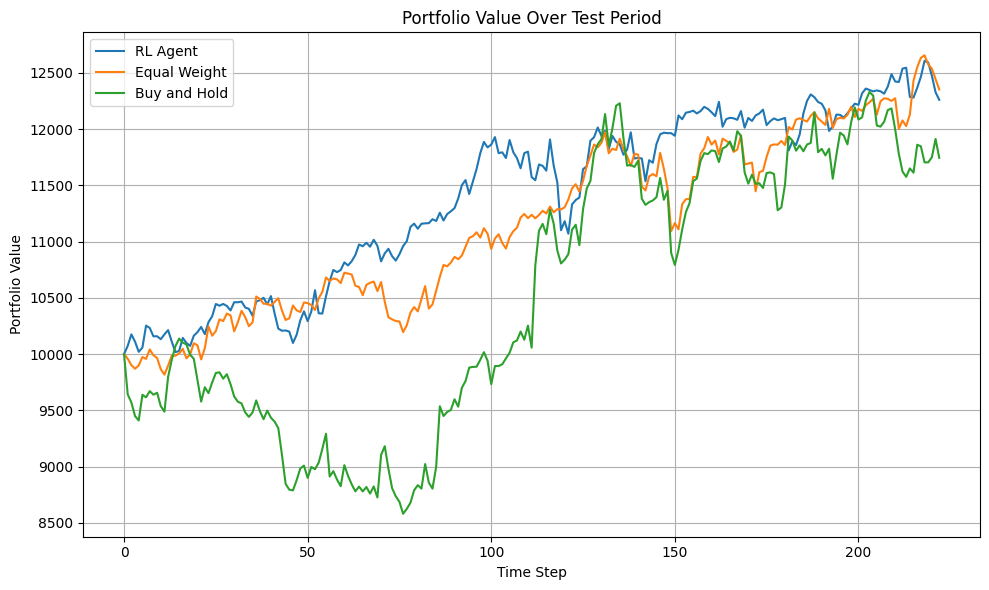

In [108]:
if __name__ == "__main__":
    # Determine number of evaluation steps
    n_steps = len(rl_vals)

    # Initialize benchmark strategy portfolios
    equal_weight_vals = [1e4]
    buy_and_hold_vals = [1e4]

    # Define static weights for benchmarks
    equal_weight_w = np.ones(len(tickers)) / len(tickers)
    buy_and_hold_w = np.zeros(len(tickers))
    buy_and_hold_w[0] = 1.0  # Invest entirely in first asset

    # Simulate benchmark strategies
    for lr in test_df.values[:n_steps - 1]:
        equal_weight_vals.append(equal_weight_vals[-1] * np.exp(np.dot(equal_weight_w, lr)))
        buy_and_hold_vals.append(buy_and_hold_vals[-1] * np.exp(np.dot(buy_and_hold_w, lr)))

    # Plot the portfolio values over time
    plt.figure(figsize=(10, 6))
    plt.plot(rl_vals, label='RL Agent')
    plt.plot(equal_weight_vals, label='Equal Weight')
    plt.plot(buy_and_hold_vals, label='Buy and Hold')
    plt.title('Portfolio Value Over Test Period')
    plt.xlabel('Time Step')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Conclusion & Future Work

- The PPO-based reinforcement learning agent successfully learned to dynamically rebalance a portfolio across major stocks.
- The model demonstrated the ability to adapt allocations based on observed price dynamics, capturing risk-adjusted returns effectively.

### Potential Improvements

- **Feature Engineering**: Incorporate additional features such as technical indicators (e.g., RSI, MACD) or macroeconomic variables.
- **Model Architecture**: Utilize recurrent architectures (e.g., LSTM) to better capture temporal dependencies in financial data.
- **Market Coverage**: Extend the environment to include a broader set of assets, including ETFs, commodities, or international equities.
- **Realism**: Integrate slippage, leverage constraints, and realistic execution costs to enhance deployment viability.

---

## Next Steps

- **Cross-Sector Evaluation**: Train and evaluate the agent on alternative asset groups (e.g., energy, small-cap equities, or fixed income).
- **Hybrid Strategies**: Combine RL-driven signals with traditional finance heuristics, such as value or momentum filters, to improve robustness.
- **Meta-Learning**: Explore ensemble learning or meta-RL approaches to enhance adaptability across different market regimes.
